In [1]:
import numpy as np
import pandas as pd
import random
import statistics as st
import matplotlib.pyplot as plt
import re
import time
#First we have to get the aircraft type and decide the seats, the user can input the aircraft type 
#create a dictionary in which the key is the aircraft type and the value is capability

class flight:

    aircraft_type = {'Boeing737': 118, 'Boeing757': 170, 'Boeing767': 235,
                     '': 321, 'Boeing787': 270, 'A350': 348}
    
    spec_day = {'01-15', '05-28', '07-04', '09-03', '10-08', '11-11', '11-22', '12-25'}

    def __init__(self, type, capacity, is_spec_day):
        self.type = type
        self.capacity = capacity
        self.is_spec_day = is_spec_day

    @classmethod
    def get_attributes(cls):
        
        localtime = time.strftime('%m-%d',time.localtime(time.time()))
        is_spec_day = localtime in flight.spec_day
        
        type = input('Aircraft type: ')

        pattern = re.compile(r'(Boeing7[35678]7)|(A350)', re.I)
        m = pattern.match(type)
        
        if m:
            if type[0] == 'B' or type[0] == 'b':
                type = 'Boeing' + type[-3:]
            else:
                type = 'A' + type[-3:]

            capacity = flight.aircraft_type[type]
            return cls(type, capacity, is_spec_day)
        else:
            print('This is invalid aircraft type. Please try again.')
            return flight.get_capacity()

In [2]:
#We assumen that demand and overbooking are both binormal distribution
def get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity):
    demand_num = np.random.binomial(demand_hyp, demand_prob)###question demand有可能大于capacity吗？
    if demand_num <= capacity:
        sales_num = demand_num #np.random.binomial(capacity + overbook_num, demand_prob)
    else:
        sales_num = capacity + overbook_num 
    showup_num = np.random.binomial(sales_num, showup_prob)
    return sales_num, showup_num

In [3]:
def get_rev(sales_num, capacity, showup_num, profit, is_spec_day):
    loss = []
    if showup_num <= capacity:
        revenue = profit*sales_num #assume no refund for the no_show
    else:
        for i in range(showup_num - capacity):
        #compensation according to the us federal, waiting for 1 tp 2 hours you need to compensate 
        #up to 400 dollars.....
            if is_spec_day:
                compensation = np.random.choice(np.array([400,800]), p=[0.75, 0.25])
            else:
                compensation = np.random.choice(np.array([0,400,800]), p=[0.6, 0.3, 0.1])
            single_loss = compensation
            loss.append(single_loss)
        revenue = profit*sales_num - sum(loss)
    return revenue

In [4]:
def Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, demand_hyp_ec, is_spec_day):
    simu_result = {'revenue_means': [], 'plot_1': []}
    fare_class = ["business", "economics"]

    for i in range(0, 30):  # overbooking range is 1 and 30
        total_revenue_list = []
        revenue_ec, revenue_bu = [], []
        for n in range(1000):
            overbook_ec = random.randint(0, i + 1)
            overbook_bu = i - overbook_ec
            revenue_list = []
            for cs in fare_class:
                if cs == "business":
                    cost = 150  # of each seat
                    profit = cost * 0.4
                    capacity = int(capacity_all * 0.2)
                    overbook_num = overbook_bu
                    demand_hyp = demand_hyp_bu
                else:
                    cost = 100  # of each seat
                    profit = cost * 0.2
                    capacity = capacity_all - capacity
                    overbook_num = overbook_ec
                    demand_hyp = demand_hyp_ec
                    
                variables = get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity)
                sales_num = variables[0]
                showup_num = variables[1]
                revenue = get_rev(sales_num, capacity, showup_num, profit, is_spec_day)
                revenue_list.append(revenue)

            revenue_ec.append(revenue_list[0])
            revenue_bu.append(revenue_list[1])
            total_revenue = sum(revenue_list)
            total_revenue_list.append(total_revenue)

        revenue_mean = st.mean(total_revenue_list)
        revenue_mean_ec = st.mean(revenue_ec)
        revenue_mean_bu = st.mean(revenue_bu)
        simu_result['revenue_means'].append((i, revenue_mean_bu, revenue_mean_ec, revenue_mean))
        simu_result['plot_1'].append(revenue_mean)

    return simu_result

In [5]:
def get_plot(simu_result):
    plot = plt.plot(simu_result['plot_1'])
    
    return plot

In [6]:
def get_frame(simu_result):
    frame = pd.DataFrame(data = simu_result['revenue_means'], columns = ['Overbooking Number', 'Business Revenue', 
                                                                         'Economic Revenue', 'Estimated Total Revenue'])
    
    return frame

In [7]:
def get_max_rev(frame, capacity_all):
    frame = frame.assign(**{
        'Overbooking Percentage': lambda x: x['Overbooking Number'] / capacity_all * 100
    })
    frame = frame.assign(**{
    'Overbooking Percentage': lambda x: x['Overbooking Percentage'].map('{:.2f}%'.format)
    })
    
    max_revenue = frame.loc[frame['Estimated Total Revenue'].idxmax()]
    
    return max_revenue

Aircraft type: Boeing737
False


,Overbooking Number,Business Revenue,Economic Revenue,Estimated Total Revenue
0,0,1816.22,1348.98,3165.20
1,1,1724.92,1325.80,3050.72
2,2,1622.60,1282.88,2905.48
3,3,1525.30,1203.50,2728.80
4,4,1492.40,1168.74,2661.14
5,5,1375.68,1104.34,2480.02
6,6,1253.66,1070.40,2324.06
7,7,1217.08,963.32,2180.40
8,8,1113.06,933.80,2046.86
9,9,1042.42,877.14,1919.56


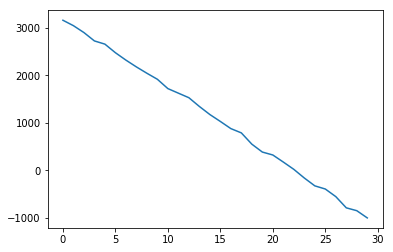

In [10]:
if __name__ == '__main__':
    # hypothesis premise
    # capacity_all = 300
    flight = flight.get_attributes()
    capacity_all = flight.capacity
    showup_prob = 1
    demand_prob = 0.9
    demand_hyp_bu = int(capacity_all * 1.2 * 0.2)  # assume largest demand is about 120% of the capacity
    demand_hyp_ec = int(capacity_all * 1.2) - demand_hyp_bu

    print(flight.is_spec_day)
    simu_result = Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, demand_hyp_ec, flight.is_spec_day)
    frame = get_frame(simu_result)

get_plot(simu_result)
frame

# pd.DataFrame(data = result['revenue_means'], columns = ['Overbooking Number', 'Business Revenue',
#'Economic Revenue', 'Estimated Total Revenue'])          

In [9]:
#print("overbooking percentage is %.2f" %(overbooking_percentage))   
get_max_rev(frame, capacity_all)

Overbooking Number               5
Business Revenue           1955.22
Economic Revenue           1425.54
Estimated Total Revenue    3380.76
Overbooking Percentage       4.24%
Name: 5, dtype: object